In [1]:
!pip install deap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install bitstring

     |████████████████████████████████| 195 kB 403 kB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-py3-none-any.whl size=37946 sha256=393686cdaddeb626dc1f6ffec6c2a063930a1efc64aed830cae673157c4ab7cd
  Stored in directory: /root/.cache/pip/wheels/de/df/5d/fb4c06c6f1469ae5a826a471cab0cbb5661f6fff9be1cd493e
Successfully built bitstring
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install transforms3d

     |████████████████████████████████| 62 kB 255 kB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59372 sha256=8d25c6dc6232dd2bdbfbf747c1c7f5b31b3c9bea9f4e23dfb15a13d54a343ed0
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!pip install tsaug

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [6]:
pwd

'/kaggle/working'

In [7]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [8]:
df = pd.read_csv('../input/covid-maroc-until-august-15/owid-covid-data.csv')

In [9]:
# Informations dur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36984 entries, 0 to 36983
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         36920 non-null  object 
 1   continent                        36691 non-null  object 
 2   location                         36984 non-null  object 
 3   date                             36984 non-null  object 
 4   total_cases                      36632 non-null  float64
 5   new_cases                        36632 non-null  float64
 6   total_deaths                     36632 non-null  float64
 7   new_deaths                       36632 non-null  float64
 8   total_cases_per_million          36568 non-null  float64
 9   new_cases_per_million            36568 non-null  float64
 10  total_deaths_per_million         36568 non-null  float64
 11  new_deaths_per_million           36568 non-null  float64
 12  new_tests         

In [10]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [11]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [12]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [13]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [14]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [15]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [16]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [17]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [18]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [19]:
df = df.fillna(df.median())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [20]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [21]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [22]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [23]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [24]:
#df['month'] = df['date'].dt.month

In [25]:
nb_seq=2
n_out=7
nb_col=5

In [26]:
start_date = '2020-03-02'
end_date = '2020-07-13'
start_date2 ='2020-07-12'
end_date2 = '2020-08-15'

In [27]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [28]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [29]:
df.sort_values(by=['location'], inplace=True)


In [30]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(134, 7)

In [31]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [32]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [33]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [34]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [35]:
X_train.shape

(134, 7)

In [36]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [37]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23052,319.0,13288.0,230.0,1.0,36910558.0,2020-07-04,Morocco
23053,534.0,13822.0,232.0,2.0,36910558.0,2020-07-05,Morocco
23054,393.0,14215.0,235.0,3.0,36910558.0,2020-07-06,Morocco
23055,114.0,14329.0,235.0,0.0,36910558.0,2020-07-07,Morocco
23056,0.0,14329.0,235.0,0.0,36910558.0,2020-07-08,Morocco
23057,442.0,14771.0,242.0,7.0,36910558.0,2020-07-09,Morocco
23058,178.0,14949.0,242.0,0.0,36910558.0,2020-07-10,Morocco
23059,379.0,15328.0,243.0,1.0,36910558.0,2020-07-11,Morocco
23060,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
23061,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco


In [38]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(35, 7)

In [39]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [40]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
1,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
2,214.0,15542.0,245.0,2.0,36910558.0,2020-07-12,Morocco
3,203.0,15745.0,250.0,5.0,36910558.0,2020-07-13,Morocco
4,191.0,15936.0,255.0,5.0,36910558.0,2020-07-14,Morocco
5,161.0,16097.0,257.0,2.0,36910558.0,2020-07-15,Morocco
6,165.0,16262.0,259.0,2.0,36910558.0,2020-07-16,Morocco
7,162.0,16424.0,260.0,1.0,36910558.0,2020-07-17,Morocco
8,302.0,16726.0,264.0,4.0,36910558.0,2020-07-18,Morocco
9,289.0,17015.0,269.0,5.0,36910558.0,2020-07-19,Morocco


In [41]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [42]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [43]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [44]:
#days=days[nb_seq:]

In [45]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(134, 5)
(134, 1)
(37, 5)
(37, 1)


In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [47]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


     var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  \
2     0.010886   0.038999      0.040   0.000000        0.0   0.001555   
3     0.001555   0.000000      0.000   0.000000        0.0   0.010886   
4     0.010886   0.038999      0.040   0.000000        0.0   0.010886   
5     0.010886   0.038999      0.040   0.000000        0.0   0.001555   
6     0.001555   0.000064      0.000   0.000000        0.0   0.010886   
..         ...        ...        ...        ...        ...        ...   
123   0.377916   0.795986      0.912   0.200000        0.0   0.160187   
124   0.160187   0.802528      0.912   0.000000        0.0   0.517885   
125   0.517885   0.823679      0.916   0.066667        0.0   0.496112   
126   0.496112   0.843940      0.920   0.066667        0.0   0.830482   
127   0.830482   0.877858      0.928   0.133333        0.0   0.611198   

     var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  ...  var1(t+5)  var2(t+5)  \
2     0.000000      0.000   0.000000        0

In [49]:
print(X_test)

    var1(t-2)  var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  \
2    0.039611   0.000000   0.000000   0.037037        0.0   0.031390   
3    0.031390   0.008566   0.013661   0.148148        0.0   0.039611   
4    0.039611   0.000000   0.000000   0.037037        0.0   0.031390   
5    0.031390   0.008566   0.013661   0.148148        0.0   0.022422   
6    0.022422   0.016625   0.027322   0.148148        0.0   0.000000   
7    0.000000   0.023419   0.032787   0.037037        0.0   0.002990   
8    0.002990   0.030381   0.038251   0.037037        0.0   0.000747   
9    0.000747   0.037217   0.040984   0.000000        0.0   0.105381   
10   0.105381   0.049960   0.051913   0.111111        0.0   0.095665   
11   0.095665   0.062154   0.065574   0.148148        0.0   0.044843   
12   0.044843   0.071480   0.076503   0.111111        0.0   0.123318   
13   0.123318   0.085236   0.084699   0.074074        0.0   0.014200   
14   0.014200   0.092831   0.095628   0.111111        0.0   0.04

In [50]:
#col_y_need_train = df.filter(regex=("d.*"))

In [51]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
2,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
3,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
4,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.010886,0.038999,0.040,0.000000,0.0,0.004666,0.000254,0.004,0.066667,0.0
5,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0,...,0.004666,0.000254,0.004,0.066667,0.0,0.001555,0.000318,0.004,0.000000,0.0
6,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0,...,0.001555,0.000318,0.004,0.000000,0.0,0.001555,0.000381,0.004,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0,...,0.000000,0.910061,0.940,0.000000,0.0,0.687403,0.938135,0.968,0.466667,0.0
124,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0,...,0.687403,0.938135,0.968,0.466667,0.0,0.276827,0.949441,0.968,0.000000,0.0
125,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0,...,0.276827,0.949441,0.968,0.000000,0.0,0.589425,0.973514,0.972,0.066667,0.0
126,0.496112,0.843940,0.920,0.066667,0.0,0.830482,0.877858,0.928,0.133333,0.0,...,0.589425,0.973514,0.972,0.066667,0.0,0.332815,0.987106,0.980,0.133333,0.0


In [52]:
Y_train.head(5)

,var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.010886,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886
3,0.001555,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886
4,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666
5,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555
6,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555


In [53]:
#raise SystemExit("Stop right there!")

In [54]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [55]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [56]:
col_x_need_train

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.010886,0.038999,0.04,0.0,0.0,0.001555,0.0,0.0,0.0,0.0


In [57]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886


In [58]:
#raise SystemExit("Stop right there!")

In [59]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [60]:
#col_x_need_train

In [61]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(126, 7)
(29, 7)


In [62]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
2,0.010886,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886
3,0.010886,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886
4,0.001555,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666
5,0.010886,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555
6,0.010886,0.010886,0.010886,0.010886,0.004666,0.001555,0.001555


In [63]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(126, 10)
(29, 10)


,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000000,0.000,0.000000,0.0
3,0.001555,0.000000,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
4,0.010886,0.038999,0.040,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
5,0.010886,0.038999,0.040,0.000000,0.0,0.001555,0.000064,0.000,0.000000,0.0
6,0.001555,0.000064,0.000,0.000000,0.0,0.010886,0.038999,0.040,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
123,0.377916,0.795986,0.912,0.200000,0.0,0.160187,0.802528,0.912,0.000000,0.0
124,0.160187,0.802528,0.912,0.000000,0.0,0.517885,0.823679,0.916,0.066667,0.0
125,0.517885,0.823679,0.916,0.066667,0.0,0.496112,0.843940,0.920,0.066667,0.0
126,0.496112,0.843940,0.920,0.066667,0.0,0.830482,0.877858,0.928,0.133333,0.0


In [64]:
X_test

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.039611,0.000000,0.000000,0.037037,0.0,0.031390,0.008566,0.013661,0.148148,0.0
3,0.031390,0.008566,0.013661,0.148148,0.0,0.039611,0.000000,0.000000,0.037037,0.0
4,0.039611,0.000000,0.000000,0.037037,0.0,0.031390,0.008566,0.013661,0.148148,0.0
5,0.031390,0.008566,0.013661,0.148148,0.0,0.022422,0.016625,0.027322,0.148148,0.0
6,0.022422,0.016625,0.027322,0.148148,0.0,0.000000,0.023419,0.032787,0.037037,0.0
7,0.000000,0.023419,0.032787,0.037037,0.0,0.002990,0.030381,0.038251,0.037037,0.0
8,0.002990,0.030381,0.038251,0.037037,0.0,0.000747,0.037217,0.040984,0.000000,0.0
9,0.000747,0.037217,0.040984,0.000000,0.0,0.105381,0.049960,0.051913,0.111111,0.0
10,0.105381,0.049960,0.051913,0.111111,0.0,0.095665,0.062154,0.065574,0.148148,0.0
11,0.095665,0.062154,0.065574,0.148148,0.0,0.044843,0.071480,0.076503,0.111111,0.0


In [65]:
print(X_test.shape)

(29, 10)


In [66]:
nb_col=5

In [67]:
X_test.head(1)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
2,0.039611,0.0,0.0,0.037037,0.0,0.03139,0.008566,0.013661,0.148148,0.0


In [68]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(29, 1, 10) (29, 7) (126, 1, 10) (126, 7)


In [69]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(29, 1, 10) (29, 7) (126, 1, 10) (126, 7)


In [70]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [71]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [72]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    #print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=6,batch_size=1, validation_data=(X_test[[0,7,14,21,28]], Y_test[[0,7,14,21,28]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14,21,28]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14,21,28]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  247 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0307 - val_loss: 0.1096
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0902
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0860
Epoch 4/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0693
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0833
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0714
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 247)            5187      
_________________________________________________________________
flatten (Flatten)            (None, 247)               0         
______

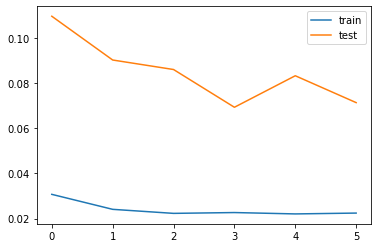

(126, 7)
(126, 7)
(126, 7)
score_train: [185.114] 168.4, 184.4, 190.9, 182.1, 180.9, 192.1, 195.6
(29, 1, 10)
score_test: [357.410] 379.7, 273.3, 143.7, 241.1, 440.3, 432.8, 464.0

RMSE test:  357.40962721668734 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.0871
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0763
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0797
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0691
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0686
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0975
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape             

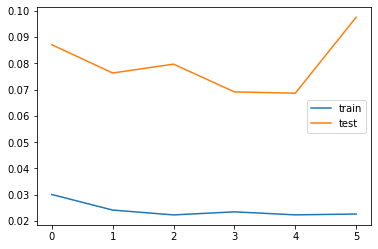

(126, 7)
(126, 7)
(126, 7)
score_train: [199.260] 175.7, 199.8, 213.5, 184.5, 211.2, 202.7, 204.5
(29, 1, 10)
score_test: [417.886] 373.6, 350.4, 226.3, 248.9, 547.9, 519.0, 526.6

RMSE test:  417.8858883558731 


Units CNN1:  223 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0943
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0851
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0719
Epoch 4/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0220 - val_loss: 0.0622
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0773
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0537
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              

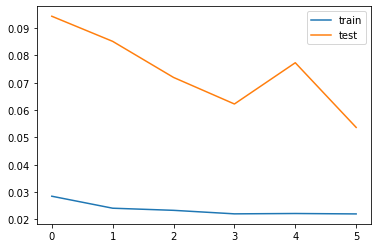

(126, 7)
(126, 7)
(126, 7)
score_train: [198.913] 171.1, 195.2, 204.6, 212.4, 191.4, 213.5, 200.8
(29, 1, 10)
score_test: [309.946] 309.5, 265.2, 109.2, 151.8, 400.5, 361.4, 424.7

RMSE test:  309.94556341438755 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 4ms/step - loss: 0.0271 - val_loss: 0.1041
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0948
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0748
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0629
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0753
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0818
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape             

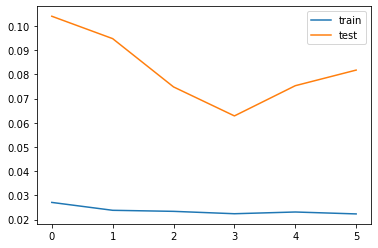

(126, 7)
(126, 7)
(126, 7)
score_train: [188.561] 179.4, 184.4, 189.2, 186.8, 189.5, 192.1, 197.9
(29, 1, 10)
score_test: [382.689] 387.2, 304.6, 130.0, 286.7, 527.3, 464.5, 435.3

RMSE test:  382.6890967473168 


Units CNN1:  95 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.1151
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0758
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0873
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0886
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0815
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0819
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              P

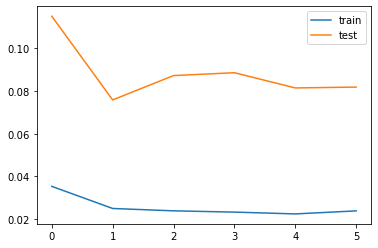

(126, 7)
(126, 7)
(126, 7)
score_train: [194.968] 171.6, 194.8, 211.6, 190.9, 193.7, 194.9, 204.9
(29, 1, 10)
score_test: [382.817] 324.6, 331.4, 171.1, 277.5, 491.2, 463.3, 498.5

RMSE test:  382.8165425559351 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0958
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0931
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0866
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0861
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0709
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0511
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              

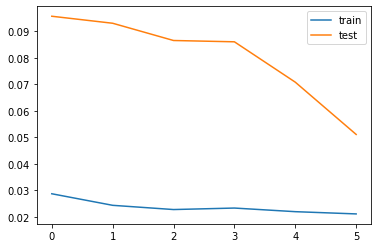

(126, 7)
(126, 7)
(126, 7)
score_train: [200.738] 182.5, 188.1, 202.2, 183.4, 198.3, 199.1, 244.8
(29, 1, 10)
score_test: [302.478] 283.3, 289.4, 213.0, 212.6, 357.9, 389.9, 325.2

RMSE test:  302.47816362812705 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0755
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0906
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0683
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0859
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0833
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0684
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape             

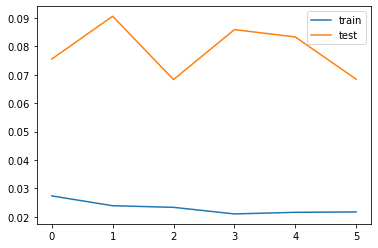

(126, 7)
(126, 7)
(126, 7)
score_train: [190.983] 178.8, 184.8, 192.7, 185.1, 185.0, 195.3, 213.2
(29, 1, 10)
score_test: [349.938] 325.1, 301.2, 168.0, 246.0, 424.5, 445.6, 439.5

RMSE test:  349.9377087369969 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1153
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0940
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0841
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0844
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0777
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0704
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              

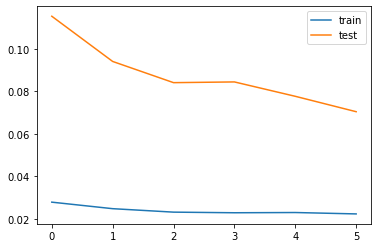

(126, 7)
(126, 7)
(126, 7)
score_train: [189.579] 168.5, 189.2, 189.3, 193.2, 183.7, 200.1, 201.1
(29, 1, 10)
score_test: [355.089] 334.7, 279.6, 140.3, 175.1, 426.9, 408.7, 541.1

RMSE test:  355.08872530224414 


Units CNN1:  127 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1049
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0907
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0923
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0778
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0793
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0836
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape             

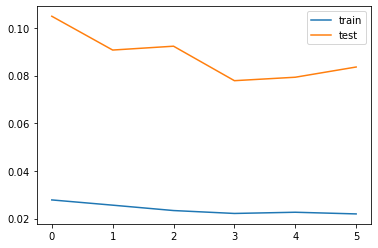

(126, 7)
(126, 7)
(126, 7)
score_train: [190.258] 175.7, 199.7, 193.3, 186.8, 182.6, 194.9, 197.6
(29, 1, 10)
score_test: [386.777] 393.1, 322.5, 135.4, 243.4, 474.3, 482.7, 503.1

RMSE test:  386.77713170078755 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0906
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0837
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0775
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0773
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0774
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0678
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape             

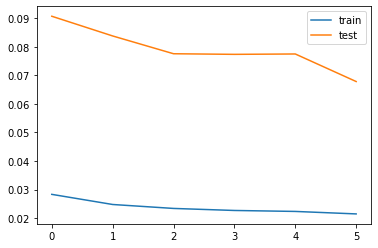

(126, 7)
(126, 7)
(126, 7)
score_train: [187.326] 166.6, 185.9, 187.3, 185.2, 197.8, 189.9, 196.8
(29, 1, 10)
score_test: [348.404] 331.5, 271.4, 129.9, 195.7, 431.3, 454.6, 467.3

RMSE test:  348.40374334911036 

gen	nevals	avg    	std    	min    	max   
0  	10    	315.705	21.1017	302.478	357.41

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0864
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.1025
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0756
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0766
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0849
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0673
Model: "sequential_10"
___________________________________

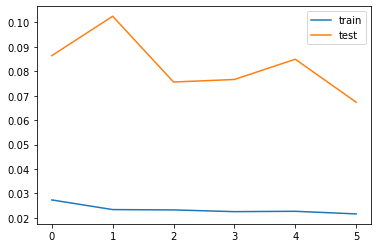

(126, 7)
(126, 7)
(126, 7)
score_train: [191.367] 174.0, 189.2, 198.1, 201.0, 180.7, 192.1, 202.7
(29, 1, 10)
score_test: [347.227] 372.3, 240.7, 111.7, 178.3, 431.3, 480.9, 431.2

RMSE test:  347.2266635227881 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0887
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0999
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0788
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0730
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0672
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0687
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape             

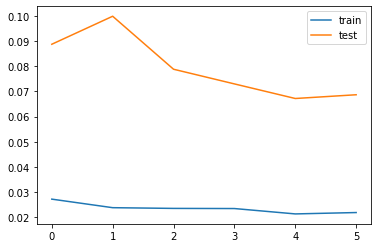

(126, 7)
(126, 7)
(126, 7)
score_train: [189.605] 171.7, 186.1, 191.3, 199.8, 186.4, 192.8, 197.9
(29, 1, 10)
score_test: [350.599] 353.5, 265.6, 132.7, 187.6, 412.9, 449.6, 489.3

RMSE test:  350.5993612888651 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 4ms/step - loss: 0.0288 - val_loss: 0.0975
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0919
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0770
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0972
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0692
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0778
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape             

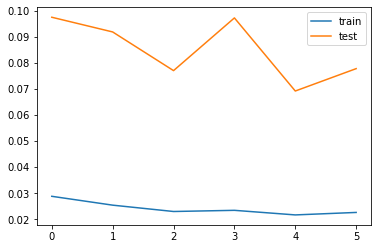

(126, 7)
(126, 7)
(126, 7)
score_train: [192.393] 184.5, 196.9, 190.9, 199.9, 185.7, 191.9, 196.4
(29, 1, 10)
score_test: [373.146] 398.7, 336.8, 122.7, 311.1, 400.2, 452.2, 475.2

RMSE test:  373.1463614269314 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.1089
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0833
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0947
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0784
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0732
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0807
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape             

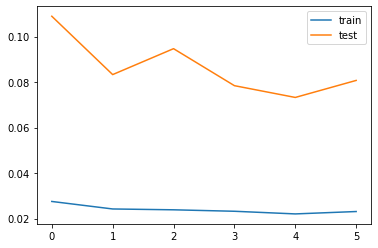

(126, 7)
(126, 7)
(126, 7)
score_train: [186.895] 168.6, 195.4, 188.9, 187.6, 177.5, 191.3, 197.4
(29, 1, 10)
score_test: [380.129] 347.6, 348.2, 137.7, 261.5, 498.1, 453.3, 478.0

RMSE test:  380.1285987354264 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0824
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0893
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0824
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0725
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0847
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0801
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape             

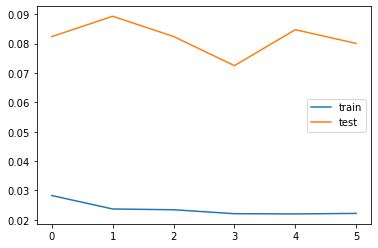

(126, 7)
(126, 7)
(126, 7)
score_train: [189.045] 170.6, 189.6, 195.6, 192.7, 178.7, 193.4, 200.9
(29, 1, 10)
score_test: [378.613] 350.2, 305.0, 154.9, 217.4, 442.6, 491.0, 528.8

RMSE test:  378.61314614768946 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.1008
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0827
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0743
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0787
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0711
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0776
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape            

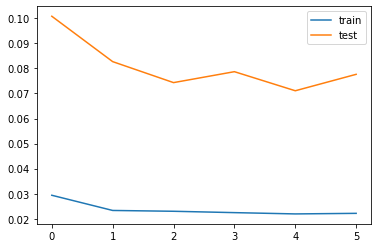

(126, 7)
(126, 7)
(126, 7)
score_train: [188.564] 171.5, 185.0, 193.7, 190.4, 183.4, 191.7, 202.7
(29, 1, 10)
score_test: [372.825] 298.2, 307.9, 136.4, 310.4, 466.0, 467.7, 488.3

RMSE test:  372.82475055126554 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0926
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0905
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0813
Epoch 4/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0224 - val_loss: 0.0942
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0225 - val_loss: 0.0642
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0755
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape            

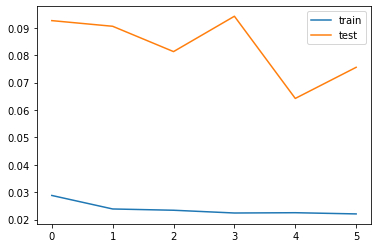

(126, 7)
(126, 7)
(126, 7)
score_train: [192.194] 172.8, 187.7, 208.4, 184.8, 193.3, 192.5, 203.6
(29, 1, 10)
score_test: [367.767] 380.6, 327.1, 101.0, 236.3, 405.3, 457.7, 505.0

RMSE test:  367.7665653186835 


Units CNN1:  223 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0864
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0889
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0769
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0743
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0715
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0687
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape             

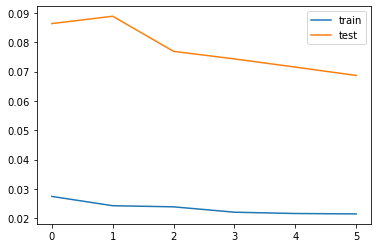

(126, 7)
(126, 7)
(126, 7)
score_train: [185.358] 166.0, 185.0, 189.9, 184.5, 181.4, 193.9, 195.1
(29, 1, 10)
score_test: [350.691] 342.5, 294.8, 117.4, 269.0, 407.6, 431.5, 467.1

RMSE test:  350.69128895234394 


Units CNN1:  247 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0855
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0783
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0786
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0708
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0706
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0708
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape            

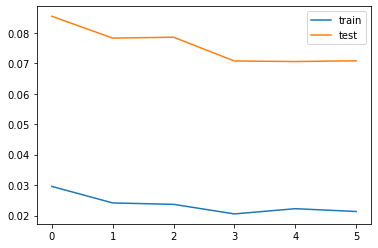

(126, 7)
(126, 7)
(126, 7)
score_train: [186.186] 172.7, 187.5, 186.5, 187.5, 181.4, 192.0, 194.9
(29, 1, 10)
score_test: [356.072] 353.5, 260.8, 141.4, 255.5, 428.2, 434.9, 486.6

RMSE test:  356.0715601909639 

1  	9     	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0737
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0886
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0682
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0723
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0653
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0804
Model: "sequential_19"
_________________________________________________________________
Layer (

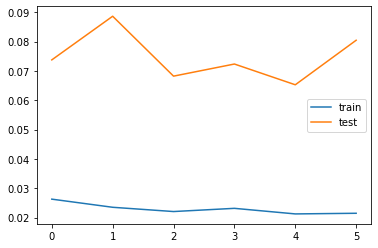

(126, 7)
(126, 7)
(126, 7)
score_train: [185.406] 169.5, 188.7, 187.6, 182.9, 178.6, 190.7, 198.4
(29, 1, 10)
score_test: [379.475] 381.4, 325.9, 144.9, 268.1, 468.4, 476.7, 465.6

RMSE test:  379.47521894374205 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0850
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0715
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0750
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0801
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0649
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0735
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape            

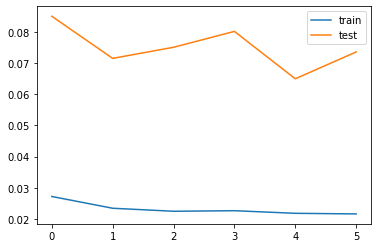

(126, 7)
(126, 7)
(126, 7)
score_train: [188.632] 167.3, 188.2, 195.0, 189.4, 187.7, 194.8, 196.4
(29, 1, 10)
score_test: [362.783] 311.3, 291.0, 168.6, 279.2, 493.3, 428.8, 454.1

RMSE test:  362.7828464687501 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 5ms/step - loss: 0.0272 - val_loss: 0.1021
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0808
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.1031
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0675
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0597
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0787
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape             

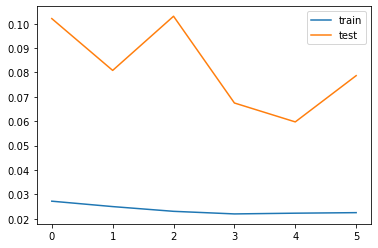

(126, 7)
(126, 7)
(126, 7)
score_train: [189.086] 170.8, 187.8, 191.5, 182.1, 184.9, 192.7, 211.3
(29, 1, 10)
score_test: [375.352] 342.1, 289.3, 129.9, 211.5, 465.3, 445.7, 555.7

RMSE test:  375.3522773792396 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0769
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0818
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0579
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0656
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0592
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0677
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape             

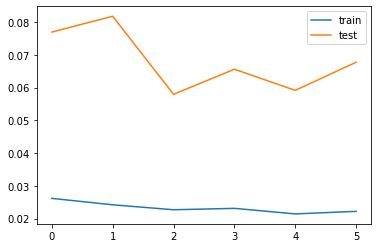

(126, 7)
(126, 7)
(126, 7)
score_train: [185.413] 168.6, 186.6, 188.9, 181.8, 180.1, 192.4, 197.9
(29, 1, 10)
score_test: [348.256] 326.5, 255.0, 131.8, 271.7, 442.0, 443.1, 441.0

RMSE test:  348.2557240172431 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0936
Epoch 2/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0244 - val_loss: 0.0832
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0883
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0693
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0793
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0704
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape             

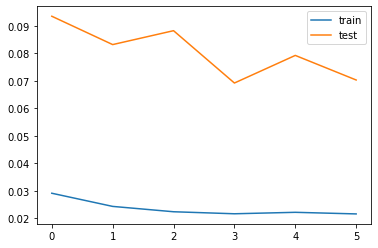

(126, 7)
(126, 7)
(126, 7)
score_train: [188.292] 174.2, 193.6, 187.6, 185.3, 186.3, 192.5, 197.7
(29, 1, 10)
score_test: [354.906] 381.8, 336.2, 134.8, 285.9, 384.5, 415.0, 450.5

RMSE test:  354.9060217051321 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0918
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0971
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0931
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0711
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0631
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0654
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape             

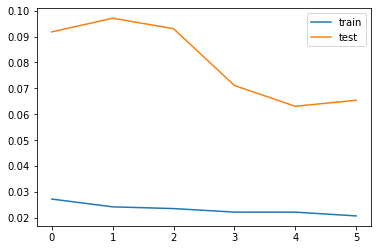

(126, 7)
(126, 7)
(126, 7)
score_train: [190.604] 189.4, 189.0, 189.9, 184.0, 180.6, 202.3, 198.1
(29, 1, 10)
score_test: [342.147] 274.8, 262.0, 127.0, 256.9, 419.9, 429.7, 481.9

RMSE test:  342.1468769959867 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.1046
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0830
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0724
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0714
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0699
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0886
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape             

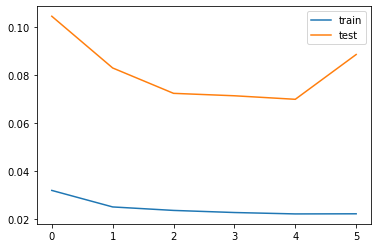

(126, 7)
(126, 7)
(126, 7)
score_train: [191.087] 172.3, 185.6, 194.2, 188.0, 188.3, 207.6, 199.7
(29, 1, 10)
score_test: [398.254] 325.8, 312.5, 146.6, 289.7, 514.8, 526.4, 508.9

RMSE test:  398.2544796958723 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.1070
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0924
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0701
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0625
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0710
Epoch 6/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0590
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape             

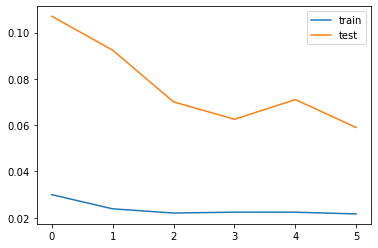

(126, 7)
(126, 7)
(126, 7)
score_train: [187.218] 167.8, 197.9, 191.1, 181.3, 185.0, 190.2, 195.6
(29, 1, 10)
score_test: [324.987] 309.9, 229.3, 133.9, 202.1, 369.9, 440.0, 448.9

RMSE test:  324.9867938032637 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1171
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0847
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0799
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0637
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0858
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0748
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape             

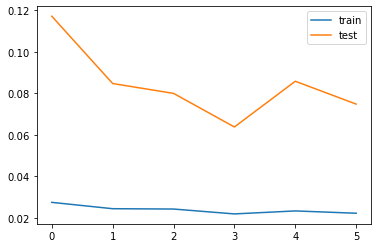

(126, 7)
(126, 7)
(126, 7)
score_train: [188.509] 173.6, 185.2, 190.2, 194.5, 183.2, 194.3, 197.4
(29, 1, 10)
score_test: [365.826] 368.1, 267.0, 117.1, 178.1, 436.2, 457.8, 533.7

RMSE test:  365.8258231225578 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0794
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0826
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0873
Epoch 4/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0226 - val_loss: 0.0717
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0680
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0803
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape             

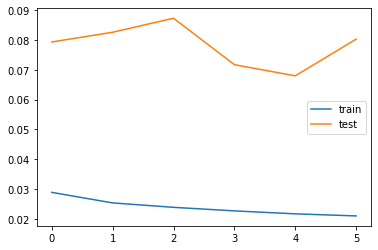

(126, 7)
(126, 7)
(126, 7)
score_train: [188.247] 168.0, 184.9, 190.8, 190.1, 191.0, 191.3, 200.1
(29, 1, 10)
score_test: [379.226] 337.4, 287.7, 148.4, 300.3, 497.1, 460.3, 488.9

RMSE test:  379.22593924767534 

2  	10    	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1198
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0838
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0663
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0774
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0677
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0775
Model: "sequential_29"
_________________________________________________________________
Layer 

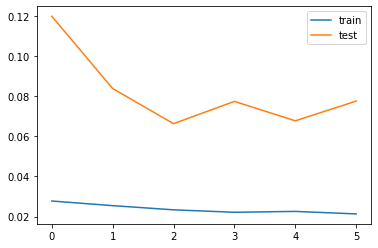

(126, 7)
(126, 7)
(126, 7)
score_train: [185.904] 176.4, 182.7, 190.2, 181.9, 179.0, 190.6, 199.4
(29, 1, 10)
score_test: [372.539] 393.6, 293.7, 115.3, 232.1, 476.1, 447.3, 486.3

RMSE test:  372.5393667395398 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 5ms/step - loss: 0.0272 - val_loss: 0.1074
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0839
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0902
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0765
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0867
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0739
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape             

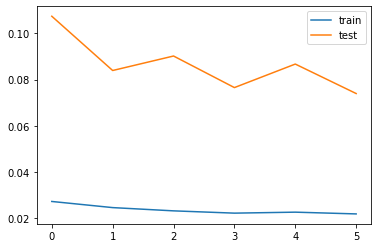

(126, 7)
(126, 7)
(126, 7)
score_train: [188.047] 167.8, 185.8, 196.1, 190.8, 180.5, 192.2, 201.2
(29, 1, 10)
score_test: [363.823] 361.1, 294.0, 108.8, 207.2, 490.0, 479.7, 429.9

RMSE test:  363.82290903279176 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.1092
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0734
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0987
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0664
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0717
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0753
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape            

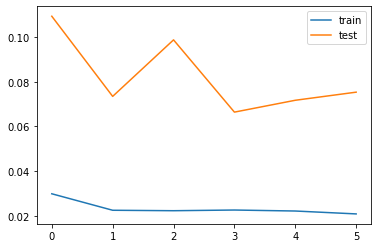

(126, 7)
(126, 7)
(126, 7)
score_train: [187.706] 167.4, 185.3, 199.7, 181.5, 183.0, 199.2, 195.7
(29, 1, 10)
score_test: [367.185] 341.3, 279.1, 217.2, 264.2, 519.0, 407.4, 444.0

RMSE test:  367.18523184631005 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0875
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0674
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0601
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0646
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0613
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0690
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape            

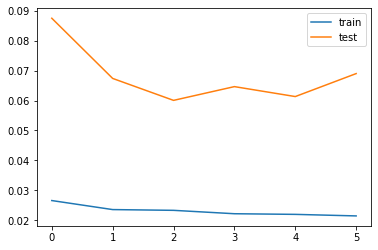

(126, 7)
(126, 7)
(126, 7)
score_train: [187.816] 171.4, 186.1, 203.4, 183.2, 181.6, 190.6, 196.7
(29, 1, 10)
score_test: [351.470] 344.8, 266.6, 98.1, 250.8, 439.2, 445.9, 458.8

RMSE test:  351.4696762675762 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.1069
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0751
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0765
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0785
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0708
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0630
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              

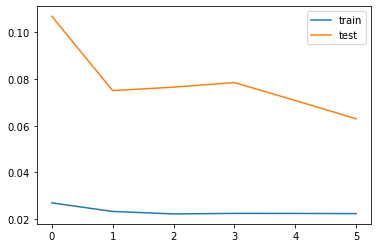

(126, 7)
(126, 7)
(126, 7)
score_train: [191.665] 169.4, 182.5, 199.4, 183.0, 194.8, 215.1, 194.2
(29, 1, 10)
score_test: [335.805] 346.3, 289.5, 120.8, 213.6, 369.2, 413.5, 467.0

RMSE test:  335.80533163148635 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0804
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0769
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0978
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0826
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0716
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0626
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape            

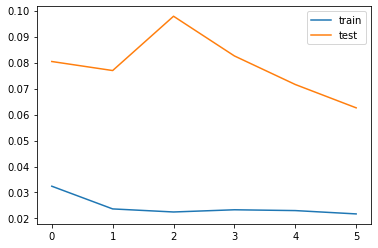

(126, 7)
(126, 7)
(126, 7)
score_train: [190.091] 167.6, 185.1, 201.4, 196.9, 180.6, 192.8, 203.7
(29, 1, 10)
score_test: [334.728] 304.7, 270.9, 102.7, 167.0, 454.6, 447.3, 415.9

RMSE test:  334.7279247116044 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.1077
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0894
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0751
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0760
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0814
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0745
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape             

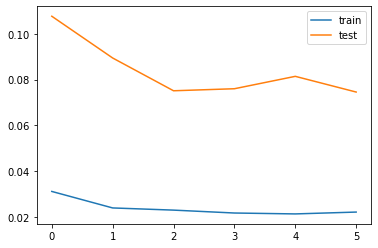

(126, 7)
(126, 7)
(126, 7)
score_train: [187.044] 170.2, 184.7, 186.6, 194.5, 179.6, 190.8, 201.3
(29, 1, 10)
score_test: [365.310] 345.5, 300.3, 137.0, 276.1, 416.5, 437.7, 514.3

RMSE test:  365.30986121564194 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0862
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0673
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0794
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0816
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0772
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0729
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape            

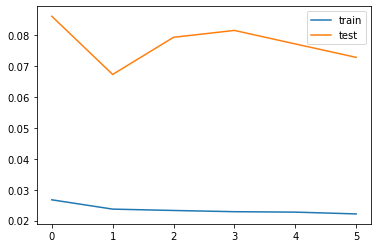

(126, 7)
(126, 7)
(126, 7)
score_train: [184.698] 167.6, 184.0, 190.7, 184.4, 180.0, 190.9, 194.2
(29, 1, 10)
score_test: [361.158] 331.5, 261.8, 145.9, 261.5, 463.8, 456.6, 470.5

RMSE test:  361.15763669496584 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0856
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0745
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0753
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0746
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0849
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0663
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape            

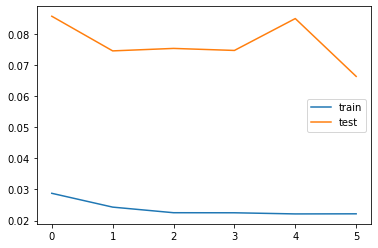

(126, 7)
(126, 7)
(126, 7)
score_train: [188.150] 171.5, 197.5, 190.1, 184.7, 184.5, 192.1, 195.4
(29, 1, 10)
score_test: [344.541] 331.7, 247.8, 127.0, 206.7, 436.8, 446.4, 458.9

RMSE test:  344.54057321365184 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0998
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0867
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0676
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0799
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0623
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0719
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape            

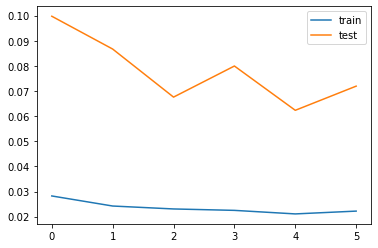

(126, 7)
(126, 7)
(126, 7)
score_train: [189.244] 168.5, 188.4, 194.2, 192.8, 179.7, 199.3, 199.7
(29, 1, 10)
score_test: [358.857] 336.6, 319.7, 113.8, 333.2, 443.9, 415.0, 438.9

RMSE test:  358.8572435946931 

3  	10    	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0905
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0672
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0806
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0861
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0641
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0842
Model: "sequential_39"
_________________________________________________________________
Layer (

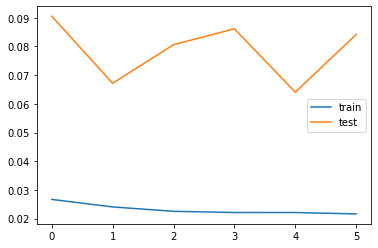

(126, 7)
(126, 7)
(126, 7)
score_train: [189.380] 171.2, 184.6, 192.4, 190.0, 180.1, 195.1, 209.9
(29, 1, 10)
score_test: [388.150] 365.5, 309.3, 150.9, 295.0, 424.5, 494.4, 539.3

RMSE test:  388.14998340641324 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0927
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0775
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0726
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0767
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0957
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0685
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape            

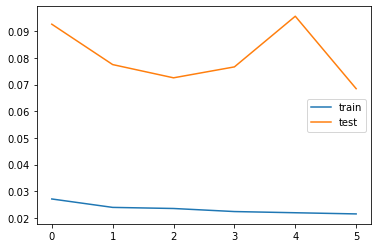

(126, 7)
(126, 7)
(126, 7)
score_train: [190.732] 167.8, 187.0, 199.3, 190.5, 189.5, 199.8, 199.2
(29, 1, 10)
score_test: [350.144] 367.2, 292.2, 188.6, 295.1, 406.0, 393.2, 442.7

RMSE test:  350.14441961477115 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.1026
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1001
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0747
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0868
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0880
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0764
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape            

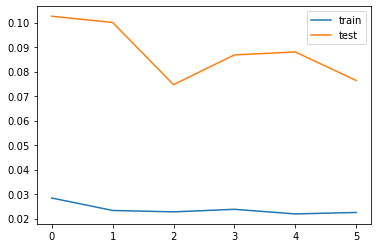

(126, 7)
(126, 7)
(126, 7)
score_train: [189.737] 170.7, 195.5, 195.8, 184.4, 183.0, 193.3, 203.5
(29, 1, 10)
score_test: [369.774] 347.4, 318.8, 152.1, 247.4, 439.5, 453.3, 501.8

RMSE test:  369.7735563766648 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0836
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0865
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0569
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0898
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0704
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0584
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape             

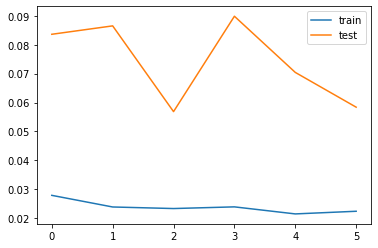

(126, 7)
(126, 7)
(126, 7)
score_train: [194.389] 194.5, 185.0, 190.3, 182.2, 182.1, 209.8, 214.1
(29, 1, 10)
score_test: [323.308] 288.0, 290.8, 131.3, 244.3, 427.4, 399.0, 381.4

RMSE test:  323.3077252356315 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0777
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0922
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0754
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0757
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0695
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0768
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape             

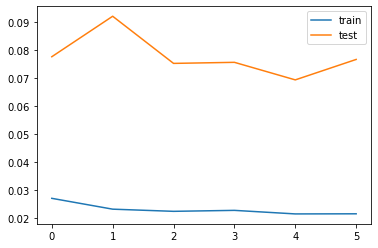

(126, 7)
(126, 7)
(126, 7)
score_train: [189.653] 170.7, 188.1, 191.7, 183.2, 185.0, 196.1, 210.4
(29, 1, 10)
score_test: [370.726] 356.9, 311.7, 132.4, 227.4, 460.7, 443.0, 509.6

RMSE test:  370.72632704169365 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0836
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0829
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0699
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0710
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0828
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0920
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape            

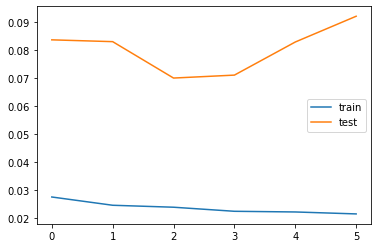

(126, 7)
(126, 7)
(126, 7)
score_train: [191.357] 168.8, 201.8, 187.9, 195.5, 194.0, 192.1, 197.5
(29, 1, 10)
score_test: [405.789] 361.6, 362.4, 129.7, 303.8, 540.4, 483.4, 505.6

RMSE test:  405.7888489991792 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.1015
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0879
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0691
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0865
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0783
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0770
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape             

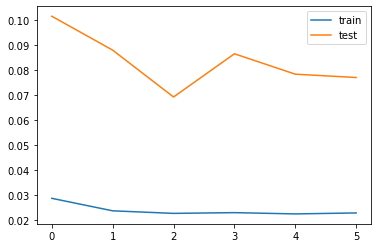

(126, 7)
(126, 7)
(126, 7)
score_train: [186.678] 167.3, 184.3, 191.1, 184.2, 181.7, 199.1, 197.1
(29, 1, 10)
score_test: [371.177] 319.5, 297.4, 133.8, 262.7, 481.0, 500.7, 452.8

RMSE test:  371.1772302159047 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.1018
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0936
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0812
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0859
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0633
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0947
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape             

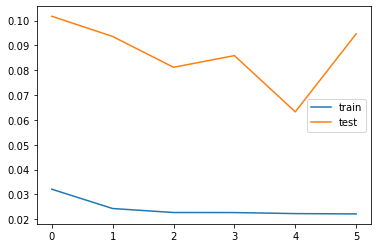

(126, 7)
(126, 7)
(126, 7)
score_train: [193.830] 168.7, 184.8, 192.8, 191.0, 198.8, 219.2, 198.0
(29, 1, 10)
score_test: [411.655] 348.8, 324.8, 118.1, 301.0, 547.7, 539.4, 513.4

RMSE test:  411.6546456473668 

4  	8     	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0926
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0742
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0795
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0759
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0670
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0694
Model: "sequential_47"
_________________________________________________________________
Layer (

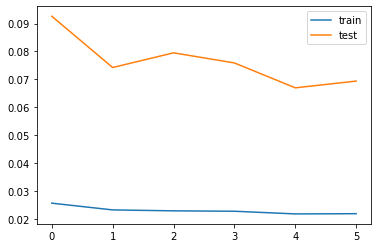

(126, 7)
(126, 7)
(126, 7)
score_train: [186.708] 172.4, 185.4, 190.0, 190.2, 179.8, 191.0, 197.1
(29, 1, 10)
score_test: [352.436] 365.1, 269.4, 134.3, 179.4, 412.4, 443.5, 496.6

RMSE test:  352.436306717524 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0859
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0891
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0791
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0875
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0665
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0708
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              

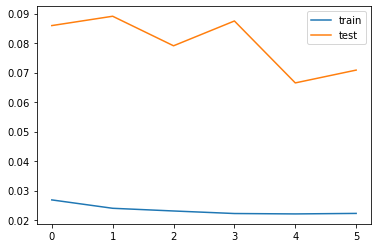

(126, 7)
(126, 7)
(126, 7)
score_train: [184.850] 168.7, 189.7, 185.7, 184.9, 179.4, 189.1, 195.3
(29, 1, 10)
score_test: [356.105] 321.9, 262.7, 129.3, 280.8, 462.8, 464.5, 435.2

RMSE test:  356.105099477283 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.1122
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0914
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0979
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0748
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0798
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0655
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              

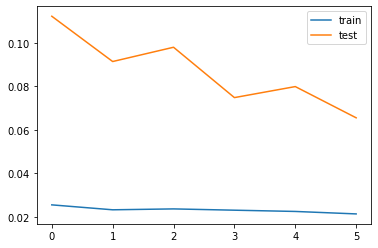

(126, 7)
(126, 7)
(126, 7)
score_train: [192.316] 175.4, 185.7, 192.4, 184.4, 184.7, 194.3, 225.3
(29, 1, 10)
score_test: [342.365] 331.3, 299.7, 110.8, 228.6, 443.0, 452.8, 393.7

RMSE test:  342.3651802689527 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0962
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0980
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0858
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0816
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0764
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0741
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape             

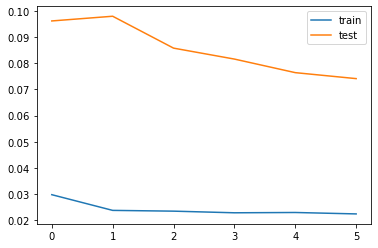

(126, 7)
(126, 7)
(126, 7)
score_train: [186.207] 170.6, 186.1, 190.0, 184.9, 181.1, 191.9, 197.6
(29, 1, 10)
score_test: [364.277] 383.3, 285.9, 151.0, 263.6, 473.3, 442.2, 434.0

RMSE test:  364.27672863094483 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.1239
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0838
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0820
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0858
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0629
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0715
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape            

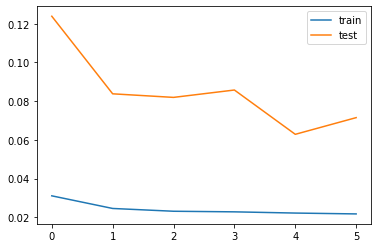

(126, 7)
(126, 7)
(126, 7)
score_train: [186.987] 172.3, 184.1, 195.0, 183.9, 183.0, 194.0, 195.5
(29, 1, 10)
score_test: [357.738] 372.6, 290.6, 105.2, 246.7, 446.0, 440.9, 455.4

RMSE test:  357.73830330245556 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0979
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.1001
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0878
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0769
Epoch 5/6
126/126 [==============================] - 1s 4ms/step - loss: 0.0218 - val_loss: 0.0694
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0783
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape            

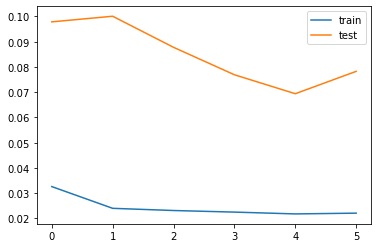

(126, 7)
(126, 7)
(126, 7)
score_train: [187.638] 168.3, 184.0, 198.3, 182.5, 191.6, 191.1, 196.0
(29, 1, 10)
score_test: [374.312] 364.1, 281.3, 161.0, 236.9, 530.3, 423.0, 476.3

RMSE test:  374.3120265297852 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1092
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0811
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0642
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0736
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0670
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.0868
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape             

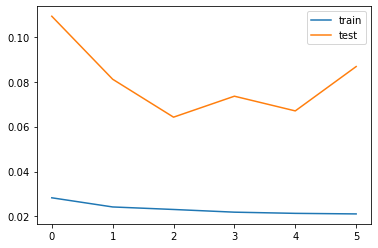

(126, 7)
(126, 7)
(126, 7)
score_train: [191.109] 181.4, 200.2, 189.2, 190.8, 183.5, 193.7, 198.1
(29, 1, 10)
score_test: [394.100] 375.2, 337.4, 138.1, 327.1, 474.3, 494.5, 486.8

RMSE test:  394.10005468613457 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0301 - val_loss: 0.0882
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0989
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0739
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0813
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0793
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0671
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape            

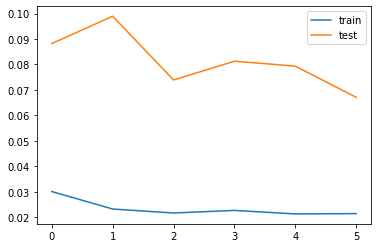

(126, 7)
(126, 7)
(126, 7)
score_train: [186.310] 166.8, 186.8, 192.0, 182.0, 178.0, 193.6, 202.7
(29, 1, 10)
score_test: [346.622] 345.3, 306.8, 127.8, 217.0, 447.2, 413.1, 440.0

RMSE test:  346.62234130074444 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0921
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0728
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0839
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0771
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0702
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0739
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape            

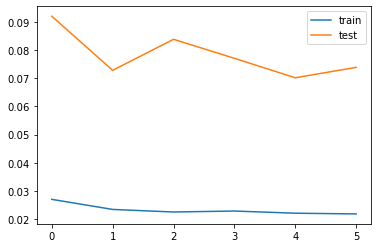

(126, 7)
(126, 7)
(126, 7)
score_train: [186.307] 170.8, 184.8, 191.3, 183.2, 180.5, 193.4, 198.7
(29, 1, 10)
score_test: [363.712] 346.7, 292.3, 108.4, 233.8, 457.1, 462.3, 480.9

RMSE test:  363.71167558433075 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0960
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0985
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0793
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0927
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0800
Epoch 6/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0989
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape            

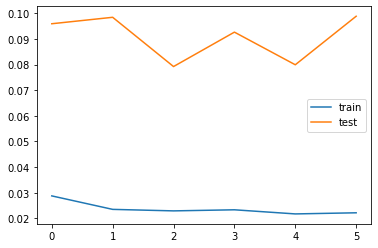

(126, 7)
(126, 7)
(126, 7)
score_train: [196.368] 171.9, 203.8, 196.5, 189.2, 187.2, 216.1, 206.6
(29, 1, 10)
score_test: [420.769] 363.6, 349.5, 189.1, 303.4, 519.9, 551.2, 532.0

RMSE test:  420.76911481557516 

5  	10    	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.1060
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0916
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0766
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0652
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0744
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0730
Model: "sequential_57"
_________________________________________________________________
Layer 

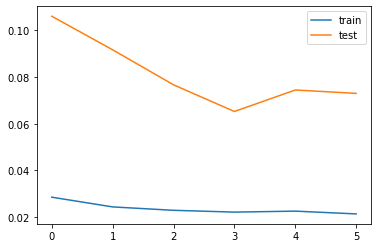

(126, 7)
(126, 7)
(126, 7)
score_train: [186.524] 171.7, 186.1, 193.6, 183.1, 181.2, 192.3, 196.5
(29, 1, 10)
score_test: [361.459] 318.2, 301.0, 171.0, 269.8, 481.4, 416.8, 463.9

RMSE test:  361.4586951092278 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1097
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0786
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0750
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0686
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0671
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0666
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape             

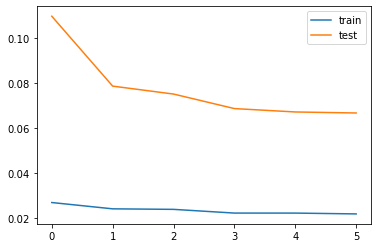

(126, 7)
(126, 7)
(126, 7)
score_train: [188.017] 168.7, 186.8, 195.1, 187.6, 187.4, 193.9, 195.2
(29, 1, 10)
score_test: [345.342] 356.0, 313.7, 120.6, 222.2, 410.2, 395.5, 470.2

RMSE test:  345.34218368602694 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.1064
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0879
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0769
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0796
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0905
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0809
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape            

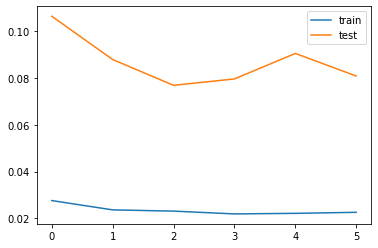

(126, 7)
(126, 7)
(126, 7)
score_train: [187.902] 170.6, 189.9, 187.1, 192.6, 180.8, 192.2, 200.7
(29, 1, 10)
score_test: [380.524] 332.3, 322.4, 134.3, 288.2, 444.1, 486.8, 513.8

RMSE test:  380.5243629410302 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0967
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0783
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0664
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0738
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0539
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0734
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape             

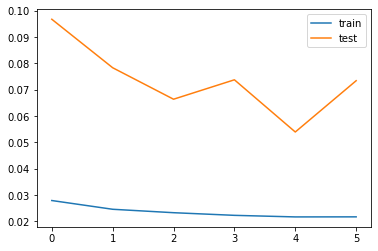

(126, 7)
(126, 7)
(126, 7)
score_train: [191.433] 184.6, 183.6, 209.5, 188.0, 182.5, 194.5, 195.7
(29, 1, 10)
score_test: [362.512] 303.9, 295.5, 111.3, 193.2, 500.9, 478.0, 459.4

RMSE test:  362.5117936526731 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0796
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0791
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0859
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0736
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0673
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0722
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape             

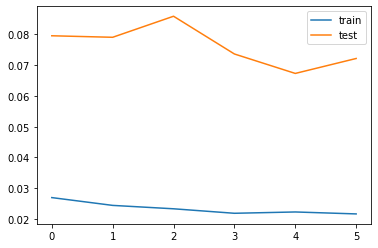

(126, 7)
(126, 7)
(126, 7)
score_train: [189.096] 173.5, 187.2, 194.8, 186.5, 193.1, 191.8, 195.8
(29, 1, 10)
score_test: [359.483] 385.6, 307.5, 111.9, 268.6, 389.7, 443.6, 477.6

RMSE test:  359.48339723888785 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0869
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0868
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0839
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0807
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0218 - val_loss: 0.0746
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0718
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape            

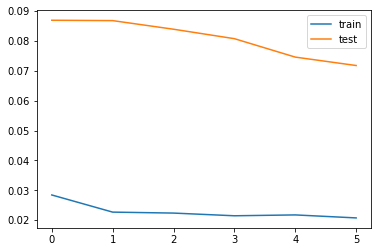

(126, 7)
(126, 7)
(126, 7)
score_train: [184.563] 169.5, 182.9, 188.1, 182.3, 179.7, 190.6, 197.6
(29, 1, 10)
score_test: [358.423] 342.8, 300.2, 130.1, 251.7, 460.0, 481.6, 409.6

RMSE test:  358.42321405576376 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0892
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0884
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0906
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0703
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0816
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0861
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape            

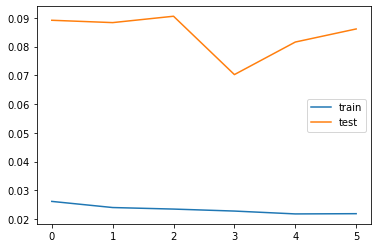

(126, 7)
(126, 7)
(126, 7)
score_train: [185.856] 167.3, 183.3, 189.1, 181.8, 180.0, 202.5, 194.9
(29, 1, 10)
score_test: [392.716] 336.8, 319.0, 172.7, 266.1, 510.8, 499.3, 503.5

RMSE test:  392.71611968742786 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0844
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0871
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0754
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0785
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0674
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0798
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape            

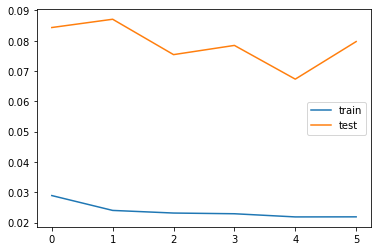

(126, 7)
(126, 7)
(126, 7)
score_train: [186.009] 174.9, 183.4, 191.2, 183.3, 181.5, 189.3, 197.5
(29, 1, 10)
score_test: [377.856] 358.1, 291.1, 156.8, 261.1, 486.9, 462.1, 493.0

RMSE test:  377.8560704732397 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0830
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.1001
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0939
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0644
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0791
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0807
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape             

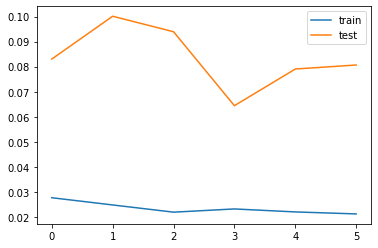

(126, 7)
(126, 7)
(126, 7)
score_train: [189.920] 168.5, 187.4, 218.0, 184.1, 181.1, 189.1, 197.5
(29, 1, 10)
score_test: [379.990] 306.5, 314.8, 199.9, 268.0, 462.2, 481.6, 510.2

RMSE test:  379.99040223006864 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.1061
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0827
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0824
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0754
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0647
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0681
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape            

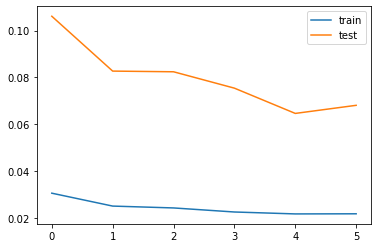

(126, 7)
(126, 7)
(126, 7)
score_train: [197.033] 169.2, 192.7, 231.3, 184.1, 200.3, 199.7, 196.4
(29, 1, 10)
score_test: [349.219] 364.1, 306.6, 97.7, 232.7, 410.9, 412.3, 473.9

RMSE test:  349.2191879749574 

6  	10    	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0259 - val_loss: 0.0860
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0873
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0873
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0678
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0725
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0692
Model: "sequential_67"
_________________________________________________________________
Layer (t

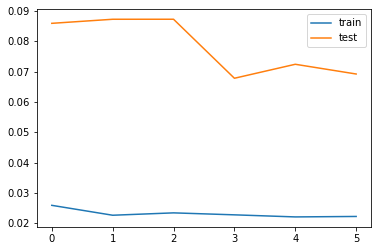

(126, 7)
(126, 7)
(126, 7)
score_train: [187.757] 168.2, 185.6, 196.2, 184.0, 181.1, 199.4, 197.8
(29, 1, 10)
score_test: [352.067] 326.7, 285.8, 150.2, 221.7, 468.5, 410.7, 468.3

RMSE test:  352.06685753409863 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 6ms/step - loss: 0.0295 - val_loss: 0.0891
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0811
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0611
Epoch 4/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0800
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0793
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0721
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape            

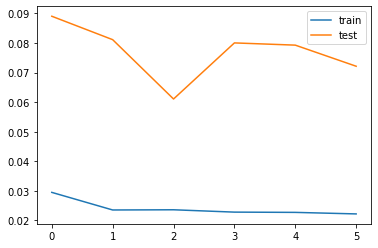

(126, 7)
(126, 7)
(126, 7)
score_train: [187.133] 165.6, 193.2, 194.2, 183.8, 181.9, 190.5, 198.7
(29, 1, 10)
score_test: [359.375] 351.6, 306.5, 110.7, 203.4, 455.2, 453.6, 469.0

RMSE test:  359.374832370344 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1005
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0984
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0606
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0622
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0615
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0715
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              

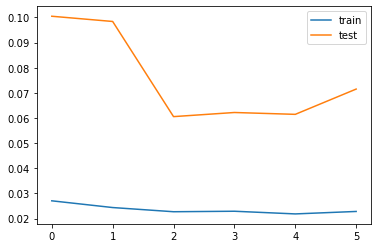

(126, 7)
(126, 7)
(126, 7)
score_train: [185.983] 169.0, 187.0, 191.6, 185.3, 180.3, 192.2, 195.2
(29, 1, 10)
score_test: [357.791] 332.6, 290.3, 155.4, 240.7, 458.3, 419.4, 482.8

RMSE test:  357.790924123494 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1098
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0956
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0787
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0847
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0773
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0863
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              

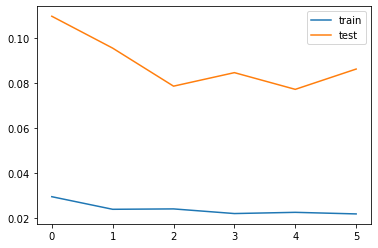

(126, 7)
(126, 7)
(126, 7)
score_train: [193.965] 181.1, 199.2, 189.6, 198.6, 182.2, 204.8, 200.9
(29, 1, 10)
score_test: [393.132] 384.6, 315.7, 140.1, 272.3, 481.4, 491.5, 516.9

RMSE test:  393.1317034858879 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1012
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0866
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0751
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0678
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0676
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0618
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape             

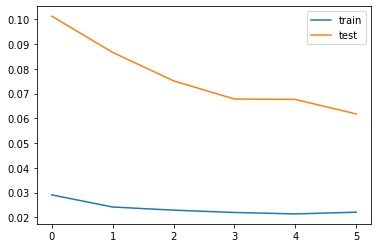

(126, 7)
(126, 7)
(126, 7)
score_train: [191.753] 170.3, 185.7, 192.0, 210.1, 180.3, 194.0, 206.8
(29, 1, 10)
score_test: [332.572] 338.5, 281.1, 137.9, 154.6, 434.9, 413.1, 421.7

RMSE test:  332.5716872105029 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0851
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0775
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0775
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0603
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0738
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0736
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape             

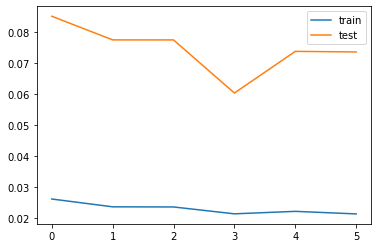

(126, 7)
(126, 7)
(126, 7)
score_train: [190.414] 175.7, 196.1, 192.2, 189.0, 179.6, 195.4, 203.3
(29, 1, 10)
score_test: [362.976] 361.9, 332.7, 165.6, 170.9, 433.6, 414.9, 513.7

RMSE test:  362.9756775341548 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0894
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0782
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0918
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0762
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0762
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0665
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape             

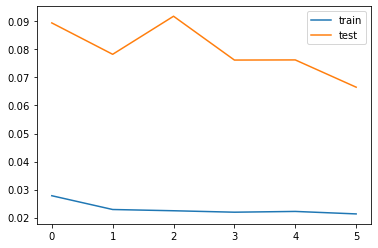

(126, 7)
(126, 7)
(126, 7)
score_train: [187.516] 168.3, 189.8, 187.6, 188.7, 185.5, 189.3, 201.9
(29, 1, 10)
score_test: [345.067] 310.7, 261.7, 157.5, 296.0, 410.3, 467.6, 411.3

RMSE test:  345.0668489959823 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0950
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.1098
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0834
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0801
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0817
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0811
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape             

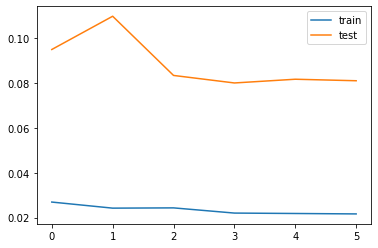

(126, 7)
(126, 7)
(126, 7)
score_train: [187.695] 167.0, 183.8, 189.0, 183.3, 186.1, 206.8, 195.4
(29, 1, 10)
score_test: [380.950] 353.8, 314.8, 149.4, 307.5, 468.6, 485.0, 469.0

RMSE test:  380.94981814463046 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0961
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0837
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0767
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0715
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0836
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0588
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape            

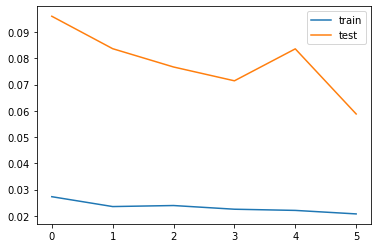

(126, 7)
(126, 7)
(126, 7)
score_train: [198.773] 203.0, 196.0, 210.7, 185.0, 181.5, 191.3, 220.9
(29, 1, 10)
score_test: [324.477] 255.1, 255.0, 101.6, 251.1, 430.4, 425.3, 409.2

RMSE test:  324.4771276182333 

7  	9     	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0997
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0989
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0833
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0780
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.1006
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0910
Model: "sequential_76"
_________________________________________________________________
Layer (

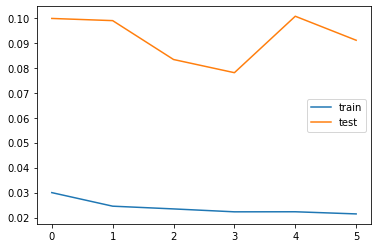

(126, 7)
(126, 7)
(126, 7)
score_train: [193.776] 168.5, 185.3, 201.4, 200.9, 186.7, 212.1, 198.4
(29, 1, 10)
score_test: [403.633] 357.6, 283.0, 196.4, 304.7, 521.4, 509.2, 519.5

RMSE test:  403.6329493565478 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1048
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0845
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0939
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0890
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0661
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0863
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape             

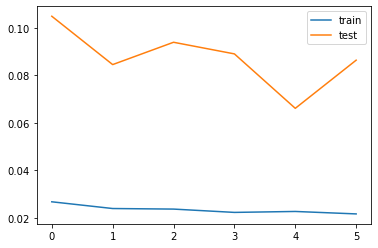

(126, 7)
(126, 7)
(126, 7)
score_train: [189.123] 168.3, 185.4, 189.2, 191.3, 189.9, 198.1, 200.0
(29, 1, 10)
score_test: [393.149] 338.3, 277.1, 155.4, 289.8, 481.4, 507.6, 541.5

RMSE test:  393.14928525647554 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 6ms/step - loss: 0.0295 - val_loss: 0.0812
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0835
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0603
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0778
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0896
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0771
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape            

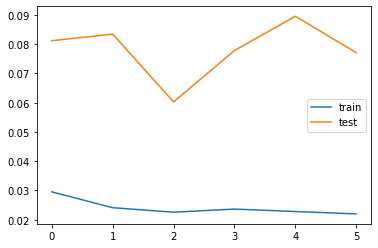

(126, 7)
(126, 7)
(126, 7)
score_train: [189.800] 171.5, 192.6, 197.3, 185.0, 189.2, 194.8, 196.9
(29, 1, 10)
score_test: [371.600] 354.3, 317.4, 158.2, 216.2, 487.1, 447.0, 481.1

RMSE test:  371.6004530944771 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0821
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0981
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0852
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0937
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0682
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0800
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape             

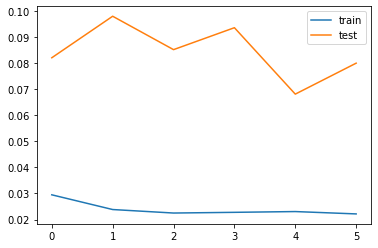

(126, 7)
(126, 7)
(126, 7)
score_train: [186.698] 167.4, 183.0, 198.5, 185.9, 184.2, 189.9, 196.4
(29, 1, 10)
score_test: [378.548] 363.6, 284.6, 171.3, 231.1, 512.2, 435.3, 505.3

RMSE test:  378.5477735984179 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0819
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0705
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0752
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0633
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0772
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0691
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape             

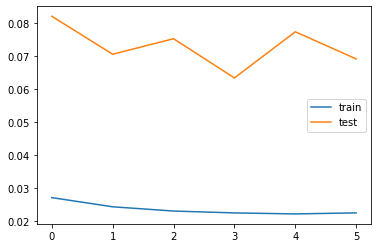

(126, 7)
(126, 7)
(126, 7)
score_train: [188.257] 169.9, 188.5, 190.3, 189.9, 182.2, 199.6, 195.8
(29, 1, 10)
score_test: [351.613] 321.6, 286.4, 105.0, 175.9, 437.2, 473.2, 472.1

RMSE test:  351.61331064095367 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0820
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0882
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0904
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0845
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0920
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0888
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape            

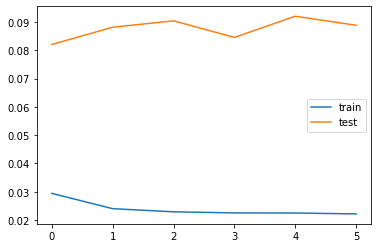

(126, 7)
(126, 7)
(126, 7)
score_train: [192.063] 179.6, 196.1, 190.0, 197.5, 179.3, 190.6, 209.6
(29, 1, 10)
score_test: [398.772] 385.0, 347.4, 132.9, 305.7, 490.1, 474.9, 517.1

RMSE test:  398.77199627055774 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0785
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0700
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0861
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0669
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0478
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0819
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape            

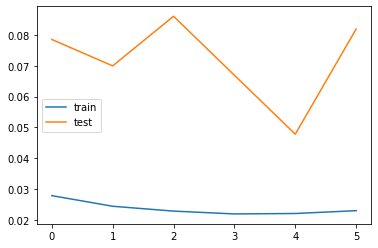

(126, 7)
(126, 7)
(126, 7)
score_train: [190.455] 176.0, 194.7, 195.5, 183.5, 180.6, 195.8, 205.4
(29, 1, 10)
score_test: [382.922] 389.5, 351.6, 172.3, 240.8, 405.3, 472.9, 524.9

RMSE test:  382.921715781146 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0946
Epoch 2/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0223 - val_loss: 0.0693
Epoch 3/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0757
Epoch 4/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0644
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0634
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0820
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              

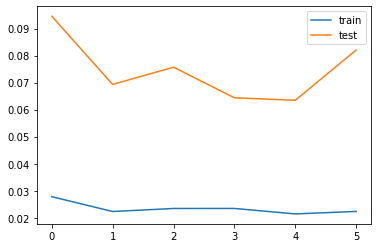

(126, 7)
(126, 7)
(126, 7)
score_train: [187.186] 168.2, 190.5, 188.6, 186.8, 180.7, 194.5, 199.4
(29, 1, 10)
score_test: [383.247] 346.0, 309.1, 147.2, 290.8, 446.7, 488.0, 518.6

RMSE test:  383.24682829915304 

8  	8     	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0902
Epoch 2/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.1106
Epoch 3/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0233 - val_loss: 0.0919
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0804
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0797
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0743
Model: "sequential_84"
_________________________________________________________________
Layer 

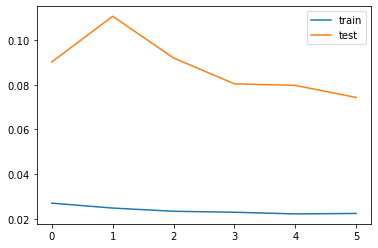

(126, 7)
(126, 7)
(126, 7)
score_train: [186.817] 168.3, 184.3, 190.3, 190.3, 185.7, 191.3, 196.1
(29, 1, 10)
score_test: [364.647] 349.8, 263.0, 135.0, 280.4, 491.6, 457.8, 437.3

RMSE test:  364.64742907578284 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1005
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0872
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0653
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0704
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0590
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0887
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape            

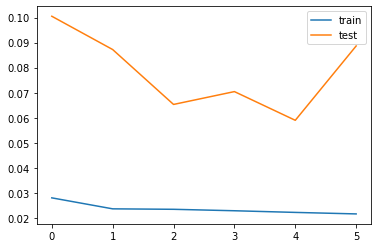

(126, 7)
(126, 7)
(126, 7)
score_train: [189.228] 178.8, 190.5, 194.0, 182.1, 186.7, 193.3, 198.4
(29, 1, 10)
score_test: [398.379] 385.0, 353.3, 194.7, 239.8, 490.6, 479.1, 521.8

RMSE test:  398.3787281856965 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0924
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0793
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0829
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0649
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0728
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0816
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape             

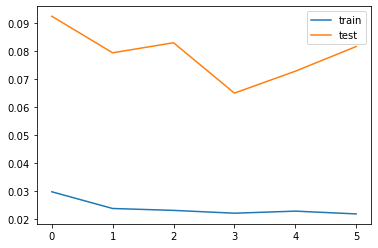

(126, 7)
(126, 7)
(126, 7)
score_train: [190.281] 168.2, 185.3, 196.8, 202.9, 186.0, 193.2, 197.5
(29, 1, 10)
score_test: [382.165] 343.7, 292.1, 194.9, 294.4, 504.3, 439.8, 496.5

RMSE test:  382.16458352149584 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0945
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0798
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0881
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0770
Epoch 5/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0809
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0736
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape            

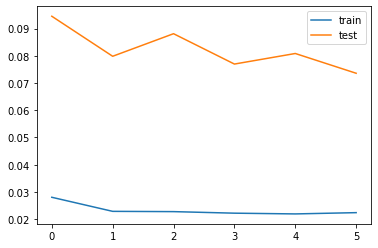

(126, 7)
(126, 7)
(126, 7)
score_train: [185.250] 167.2, 186.4, 189.5, 183.6, 181.2, 190.2, 197.1
(29, 1, 10)
score_test: [362.981] 315.4, 316.0, 163.3, 250.8, 470.9, 448.6, 458.6

RMSE test:  362.98119392454157 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 5ms/step - loss: 0.0265 - val_loss: 0.0916
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0679
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0713
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0809
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0836
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0212 - val_loss: 0.0746
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape            

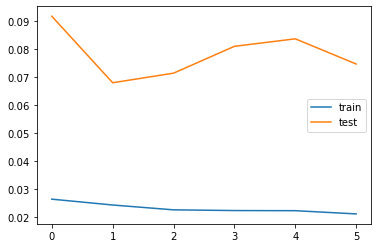

(126, 7)
(126, 7)
(126, 7)
score_train: [187.303] 168.4, 186.7, 192.6, 181.2, 182.8, 191.3, 205.9
(29, 1, 10)
score_test: [365.486] 323.7, 296.2, 125.6, 275.2, 429.2, 419.2, 539.6

RMSE test:  365.4864774032459 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0808
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0670
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0624
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0614
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0723
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0721
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape             

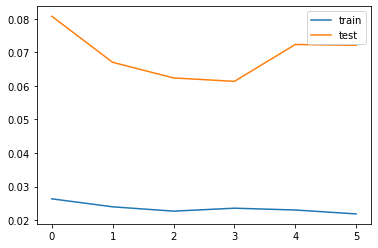

(126, 7)
(126, 7)
(126, 7)
score_train: [189.232] 170.4, 185.2, 200.3, 184.5, 188.5, 198.7, 195.3
(29, 1, 10)
score_test: [359.305] 317.1, 297.0, 102.2, 234.9, 478.5, 483.3, 432.2

RMSE test:  359.30508226914935 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0895
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0713
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0561
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0715
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0756
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0668
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape            

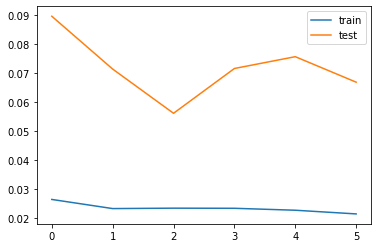

(126, 7)
(126, 7)
(126, 7)
score_train: [187.940] 170.9, 184.2, 193.5, 187.7, 188.5, 192.4, 197.3
(29, 1, 10)
score_test: [345.795] 326.1, 299.8, 150.1, 208.8, 383.1, 452.0, 472.9

RMSE test:  345.79531825248205 

9  	7     	302.478	5.68434e-14	302.478	302.478

Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0914
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.1025
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0762
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0798
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0656
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0704
Model: "sequential_91"
_________________________________________________________________
Layer 

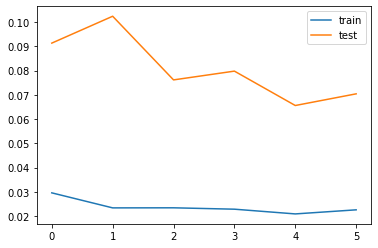

(126, 7)
(126, 7)
(126, 7)
score_train: [187.845] 171.9, 190.0, 193.7, 190.6, 181.3, 192.4, 193.9
(29, 1, 10)
score_test: [355.083] 344.3, 267.4, 118.4, 214.8, 458.0, 483.4, 434.7

RMSE test:  355.0832994850212 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0933
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0809
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0853
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0811
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0667
Epoch 6/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0820
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape             

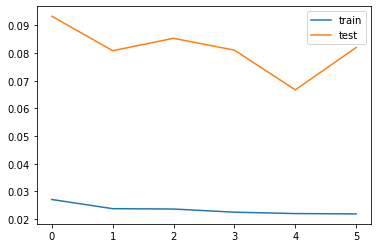

(126, 7)
(126, 7)
(126, 7)
score_train: [187.478] 169.6, 189.8, 190.3, 183.3, 186.7, 194.2, 197.2
(29, 1, 10)
score_test: [383.176] 345.2, 317.7, 146.9, 262.5, 493.4, 452.4, 518.7

RMSE test:  383.1762645586183 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.1069
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0940
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0801
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0907
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0726
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0774
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape             

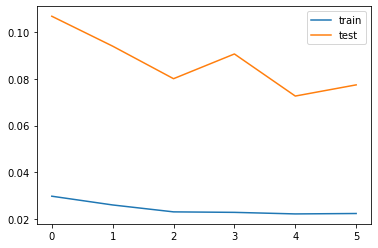

(126, 7)
(126, 7)
(126, 7)
score_train: [186.577] 171.0, 186.0, 189.6, 183.2, 181.9, 190.1, 202.7
(29, 1, 10)
score_test: [372.317] 361.3, 285.4, 135.1, 257.1, 461.8, 458.2, 500.8

RMSE test:  372.3165606759842 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0885
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0751
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0936
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0737
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0216 - val_loss: 0.0564
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0693
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape             

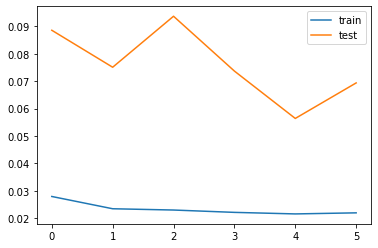

(126, 7)
(126, 7)
(126, 7)
score_train: [188.398] 174.6, 184.8, 194.3, 195.0, 180.3, 191.4, 197.2
(29, 1, 10)
score_test: [352.340] 290.6, 267.4, 150.2, 298.5, 450.4, 439.2, 453.5

RMSE test:  352.3403810523391 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0847
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0690
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0741
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0692
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0647
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0891
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape             

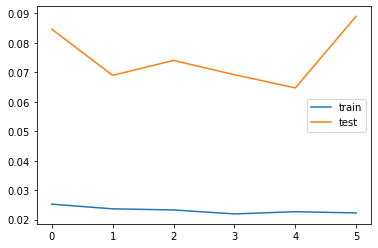

(126, 7)
(126, 7)
(126, 7)
score_train: [192.734] 169.9, 205.0, 190.1, 190.9, 193.9, 201.9, 195.3
(29, 1, 10)
score_test: [399.315] 335.7, 361.6, 116.9, 301.1, 536.0, 499.3, 481.5

RMSE test:  399.3147107906721 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 3ms/step - loss: 0.0314 - val_loss: 0.1019
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0238 - val_loss: 0.0941
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0740
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0808
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0759
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0742
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape             

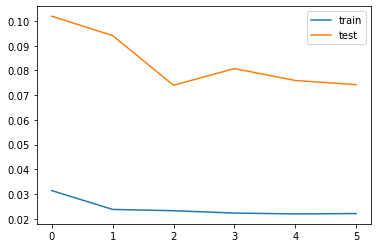

(126, 7)
(126, 7)
(126, 7)
score_train: [188.132] 174.8, 186.2, 189.1, 183.4, 186.4, 191.8, 203.9
(29, 1, 10)
score_test: [364.589] 366.8, 291.1, 131.3, 230.9, 401.5, 460.3, 517.3

RMSE test:  364.5893850708322 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1160
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0931
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0993
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0680
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0617
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0752
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape             

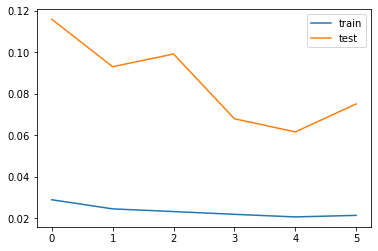

(126, 7)
(126, 7)
(126, 7)
score_train: [187.793] 173.4, 185.6, 190.3, 195.7, 180.0, 193.0, 195.4
(29, 1, 10)
score_test: [366.864] 324.5, 271.3, 127.9, 194.4, 478.2, 480.7, 499.3

RMSE test:  366.86359342152736 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 1s 4ms/step - loss: 0.0285 - val_loss: 0.0864
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0990
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0800
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0791
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0808
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0637
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape            

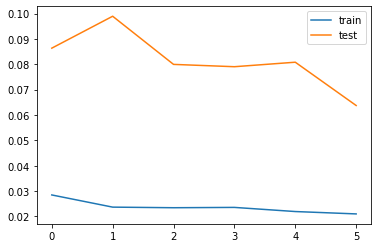

(126, 7)
(126, 7)
(126, 7)
score_train: [193.827] 170.3, 197.3, 219.1, 190.4, 180.7, 191.9, 203.3
(29, 1, 10)
score_test: [337.813] 326.0, 280.7, 145.7, 249.0, 440.0, 412.2, 408.7

RMSE test:  337.81255623714674 


Units CNN1:  255 ,Sequence size:  2
(126, 1, 10)
Epoch 1/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1098
Epoch 2/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0899
Epoch 3/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0672
Epoch 4/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0225 - val_loss: 0.0773
Epoch 5/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0903
Epoch 6/6
126/126 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0824
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape            

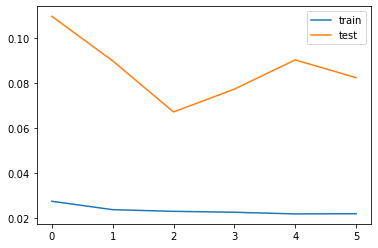

(126, 7)
(126, 7)
(126, 7)
score_train: [187.779] 167.5, 181.5, 187.6, 182.0, 180.3, 213.5, 198.7
(29, 1, 10)
score_test: [384.162] 362.9, 280.4, 127.3, 242.8, 475.2, 524.3, 496.7

RMSE test:  384.16193224167324 

10 	9     	302.478	5.68434e-14	302.478	302.478


In [74]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =8 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [75]:
print('Best score :', best_score)

Best score : 302.47816362812705


In [76]:
model=model_name
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1, 255)            5355      
_________________________________________________________________
flatten_5 (Flatten)          (None, 255)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 255)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 1792      
Total params: 7,147
Trainable params: 7,147
Non-trainable params: 0
_________________________________________________________________


In [77]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14,21,28]])
yhat.shape 

(5, 7)

In [78]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [79]:
#yhat

In [80]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14,21,28]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)

In [81]:
days

DatetimeIndex(['2020-07-12', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19',
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-01', '2020-08-02', '2020-08-03', '2020-08-04',
               '2020-08-05', '2020-08-06', '2020-08-07', '2020-08-08',
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [82]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:35]
test_res['real']=y_test_true.flatten()[0:35]
test_res.set_index(days,inplace=True)

In [83]:
test_res

,Prediction,real
timestamp,,
2020-07-12,245.845306,214.000000
2020-07-13,239.387207,203.000015
2020-07-14,211.445557,190.999985
2020-07-15,256.829803,161.000000
2020-07-16,279.554138,165.000000
2020-07-17,268.307434,162.000000
2020-07-18,319.260742,302.000000
2020-07-19,267.758575,289.000000
2020-07-20,246.711227,220.999985


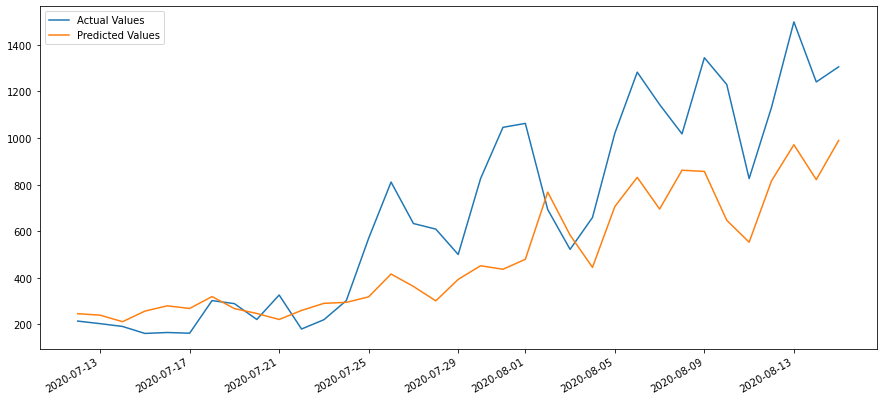

In [84]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [85]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 91493.04
RMSE: 302.48
MAE: 236.48
R Squared: 0.49
Max Error: 609.48


In [86]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(126, 7)

In [87]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(126, 7)

In [88]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [89]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [90]:
y_train_pred[0]

array([214.62996, 199.27019, 179.86948, 208.25774, 234.7708 , 232.02095,
       277.60428], dtype=float32)

In [91]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119]
y_train_pred = y_train_pred [filter_indices ]

In [92]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [93]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(126, 1, 10)

In [94]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [95]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

132

In [96]:
date_train = date_train.values.flatten()

In [97]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [98]:
Y_train_pred.shape

(126,)

In [99]:
Y_train_real.shape

(126,)

In [100]:
date_train.shape

(134,)

In [101]:
date_train[nb_seq:].shape

(132,)

In [102]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-6

In [103]:
Y_train_real[:-suite_size].shape

(6,)

In [104]:
date_train[nb_seq:].shape

(132,)

In [105]:
Y_train_pred[:-suite_size].shape

(6,)

In [106]:
Y_train_real[:-suite_size].shape

(6,)

In [107]:
date_trainX = date_train[nb_seq:]

In [108]:
date_trainX[0:Y_train_pred.shape[0]].shape

(126,)

In [109]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [110]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [111]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [112]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-04,175.566101,214.629959
2020-03-05,175.566101,199.270187
2020-03-06,163.080872,179.869476
2020-03-07,175.566101,208.257736
2020-03-08,175.566101,234.770798
2020-03-09,175.566101,232.020950
2020-03-10,175.566101,277.604279
2020-03-11,175.566101,226.423843
2020-03-12,167.242615,207.828552


In [113]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-06-28,668.732544,676.721497
2020-06-29,525.152405,626.379639
2020-06-30,656.247314,743.986694
2020-07-01,666.651672,710.706848
2020-07-02,375.329742,569.330811
2020-07-03,853.929993,531.961548
2020-07-04,824.797852,628.172363
2020-07-05,1272.185059,779.749207
2020-07-06,978.782288,713.797668


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

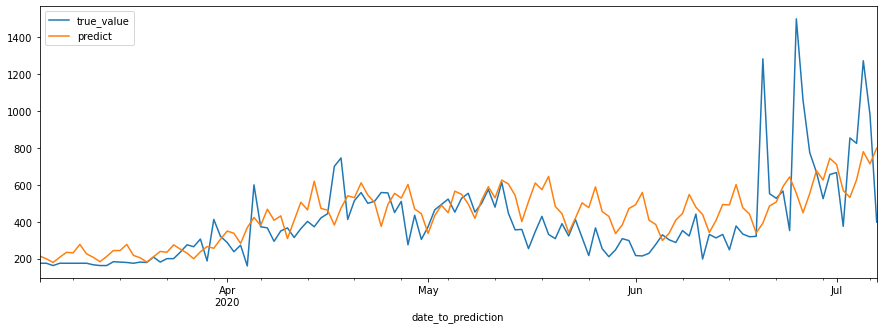

In [114]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [115]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 40295.85
RMSE 200.74
MAE 136.15
R2 0.27
maxError 1045.38
